In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
train = pd.read_csv('../data/train.csv')
train = train.drop(['id'], axis=1)

In [3]:
train.head()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


In [4]:
train["fruit_seed"] = train["fruitset"] * train["seeds"]

In [5]:
print("Train duplicates:", sum(train.drop(columns = ['yield']).duplicated()))
train = train.drop_duplicates()

Train duplicates: 14


## EDA

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
clonesize,15282.0,19.703082,6.592528,10.000000,12.500000,25.000000,25.000000,40.000000
honeybee,15282.0,0.389280,0.361695,0.000000,0.250000,0.500000,0.500000,18.430000
bumbles,15282.0,0.286768,0.059917,0.000000,0.250000,0.250000,0.380000,0.585000
andrena,15282.0,0.492704,0.148102,0.000000,0.380000,0.500000,0.630000,0.750000
osmia,15282.0,0.592373,0.139446,0.000000,0.500000,0.630000,0.750000,0.750000
MaxOfUpperTRange,15282.0,82.169762,9.147368,69.700000,77.400000,86.000000,86.000000,94.600000
MinOfUpperTRange,15282.0,49.673204,5.546810,39.000000,46.800000,52.000000,52.000000,57.200000
AverageOfUpperTRange,15282.0,68.656144,7.642362,58.200000,64.700000,71.900000,71.900000,79.000000
MaxOfLowerTRange,15282.0,59.229446,6.611121,50.200000,55.800000,62.000000,62.000000,68.200000
MinOfLowerTRange,15282.0,28.660509,3.195599,24.300000,27.000000,30.000000,30.000000,33.000000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15282 entries, 0 to 15288
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clonesize             15282 non-null  float64
 1   honeybee              15282 non-null  float64
 2   bumbles               15282 non-null  float64
 3   andrena               15282 non-null  float64
 4   osmia                 15282 non-null  float64
 5   MaxOfUpperTRange      15282 non-null  float64
 6   MinOfUpperTRange      15282 non-null  float64
 7   AverageOfUpperTRange  15282 non-null  float64
 8   MaxOfLowerTRange      15282 non-null  float64
 9   MinOfLowerTRange      15282 non-null  float64
 10  AverageOfLowerTRange  15282 non-null  float64
 11  RainingDays           15282 non-null  float64
 12  AverageRainingDays    15282 non-null  float64
 13  fruitset              15282 non-null  float64
 14  fruitmass             15282 non-null  float64
 15  seeds              

Text(0.5, 1.0, 'Yield distribution')

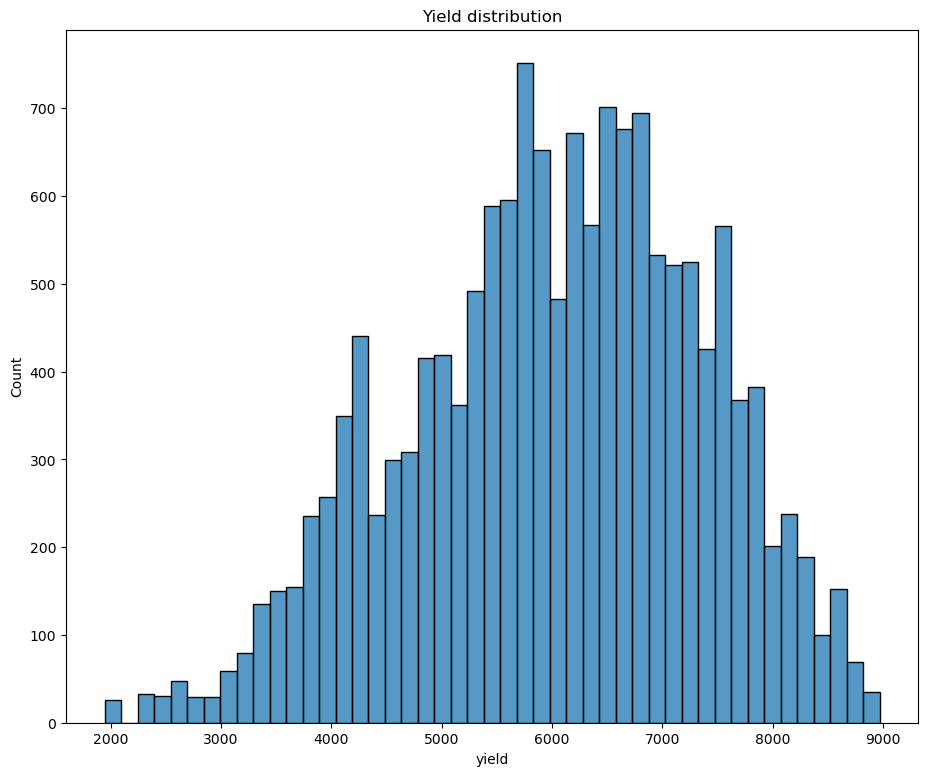

In [9]:
f, ax = plt.subplots(figsize=(11, 9))
sns.histplot(x=train['yield']).set_title('Yield distribution')

Text(0.5, 1.0, 'Correlation')

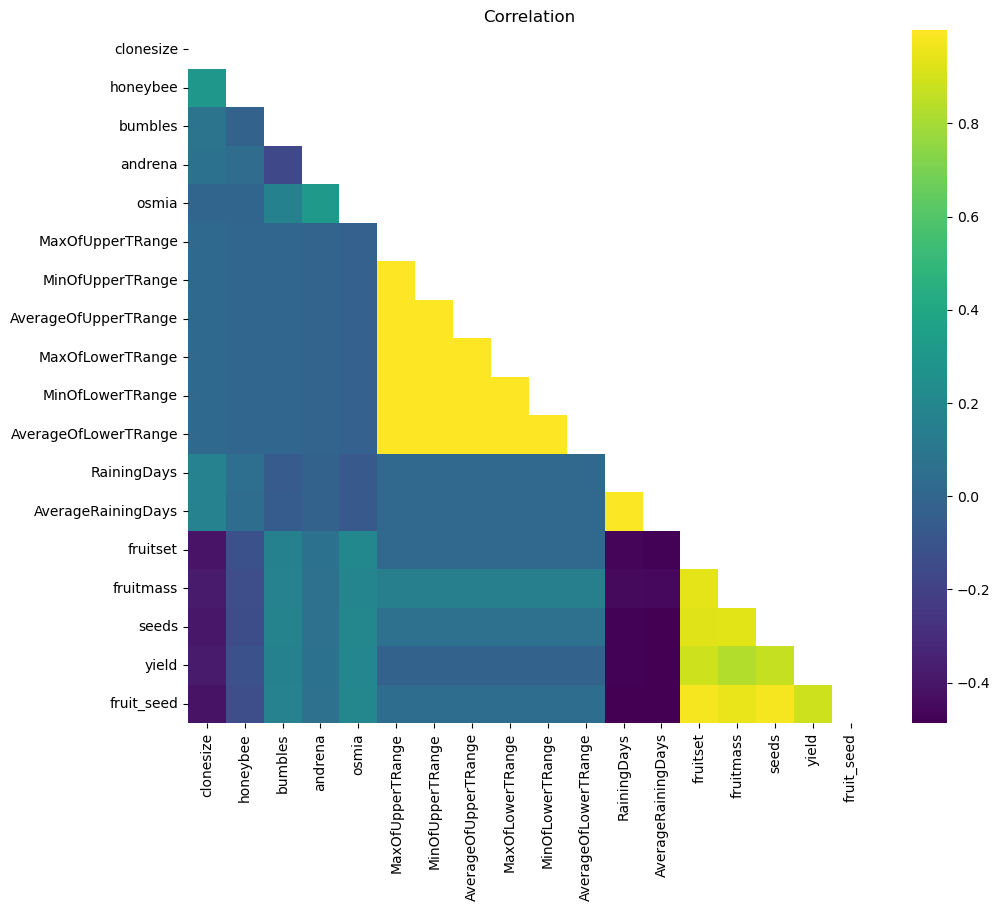

In [10]:
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(train.corr(), dtype=bool))
sns.heatmap(train.corr(), cmap='viridis', mask=mask).set_title('Correlation')

## Models

In [12]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)
X = train.copy()
y = X.pop('yield')

sc = StandardScaler()
X = sc.fit_transform(X)
# test = sc.transform(test)

unique_targets = np.sort(y.unique())

In [13]:
def find_closest_value(sorted_list, values):
    indices = np.searchsorted(sorted_list, values, side='left')
    closest_values = np.zeros_like(values)
    
    for i, index in enumerate(indices):
        if index == 0:
            closest_values[i] = sorted_list[0]
        elif index == len(sorted_list):
            closest_values[i] = sorted_list[-1]
        else:
            left_diff = values[i] - sorted_list[index-1]
            right_diff = sorted_list[index] - values[i]
            
            if left_diff < right_diff:
                closest_values[i] = sorted_list[index-1]
            else:
                closest_values[i] = sorted_list[index]
    
    return closest_values

In [14]:
def cross_val_score(model, unique_targets=None, cv = cv, label = ''):
    
    X = train.copy()
    y = X.pop('yield')
    
    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(train)))
    train_predictions = np.zeros((len(train)))
    train_mae, val_mae = [], []
    
    #training model, predicting prognosis probability, and evaluating log loss
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        model.fit(X.iloc[train_idx], y.iloc[train_idx])

        train_preds = model.predict(X.iloc[train_idx])
        val_preds = model.predict(X.iloc[val_idx])
        
        if unique_targets:
            train_preds = find_closest_value(unique_targets, train_preds)
            val_preds = find_closest_value(unique_targets, val_preds)
                  
        train_predictions[train_idx] += train_preds
        val_predictions[val_idx] += val_preds
        
        train_score = mean_absolute_error(y.iloc[train_idx], train_preds)
        val_score = mean_absolute_error(y.iloc[val_idx], val_preds)
        
        train_mae.append(train_score)
        val_mae.append(val_score)
    
    print(f'Val MAE: {np.mean(val_mae):.5f} ± {np.std(val_mae):.5f} | Train MAE: {np.mean(train_mae):.5f} ± {np.std(train_mae):.5f} | {label}')
    
    return val_mae

In [15]:
rf_params = {
    'n_estimators': 50,
    'max_depth': 10,
    'min_samples_leaf': 20,
    'max_features': None,
    'random_state': 42
}

cb_params = {
    'n_estimators': 250,
    'depth': 10,
    'learning_rate': 0.09,
    'random_strength': 0.2,
    'grow_policy': 'Lossguide',
    'bootstrap_type': 'Bayesian',
    'eval_metric': 'MAE',
    'loss_function': 'MAE',
    'random_state': 42,
    'silent': True
}

In [17]:
models = [
    ('rf', RandomForestRegressor(**rf_params)),
    ('cb', CatBoostRegressor(**cb_params)),
]

In [18]:
voter = VotingRegressor(models)

_ = cross_val_score(voter, label = 'Ensemble')

Val MAE: 343.77213 ± 9.37767 | Train MAE: 313.56838 ± 1.05562 | Ensemble
